<center><h1> Multi Subject Dictionnary Learning to segment Atlas of Brain <h1><center>

<center><h2><u> First Part: Implementation of the model on simulation data </u><h2><center>

<h2><u>1- Generation of synthetic data</u><h2>

In [88]:
from utils import *
from blob import *
import numpy as np
from sklearn.decomposition import FastICA
import matplotlib.pyplot as plt
from typing import List
import copy
from tqdm import tqdm


<h3><u>a- Group level latent spatial map</u><h3>

<span style="font-size: 15px;"> 
We first create group levels latent maps using a blob model: <br>  

- Each map is made of "a few cones-shaped localized patterns the position and size of which are chosen randomly". <br>    
- The number of blobs on each map follows a binomial distribution of parameters (3,0.5).  <br>
- We generate maps one after the other and we avoid overlapping between blob centers across the maps.  <br>
</span>


In [89]:
def create_latent_maps(grid_length: int = 50, k:int = 5):
    """_summary_

    Args:
        grid_length (int, optional): _description_. Defaults to 50.
        k (int, optional): _description_. Defaults to 5.

    Returns:
        _type_: _description_
    """
    latent_global_maps = []
    centers_to_avoid = []
    all_blobs = [] #list of lists, each containing the blobs of a latent map
    for numMap in range(k):
        # generate random blobs and add the new centers to avoid in the list for the next round
        blobs, centers_to_avoid = get_random_blobs(grid_length, max_blobs=3, centers_to_avoid=centers_to_avoid)
        # create latent maps from the generated latent maps 
        latent_global_maps.append(generate_global_map(grid_length, blobs = blobs))
        # store the given blobs 
        all_blobs.append(blobs)
    latent_global_maps = np.array(latent_global_maps)
    return latent_global_maps, all_blobs

In [90]:
grid_length = 49 # we create a map of (50,50)
k = 5 # number of latent maps we want to create
latent_global_maps, all_blobs = create_latent_maps(grid_length= grid_length, k = k ) # we create 5 goup level latent maps 

/Users/jeandmr/Documents/MVA/Semestre 1/Machine Learning for Time Series/Project/project-mva-time-series/blob.py:94: RuntimeWarning: invalid value encountered in sqrt
  min_dist = np.min([np.sqrt(np.sum(existing_center **2 - center_new_blob**2)) for existing_center in centers_to_avoid])


/var/folders/9k/c2_qmgms5bv_gzkb9tf_tc1w0000gn/T/ipykernel_6964/518695892.py:5: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


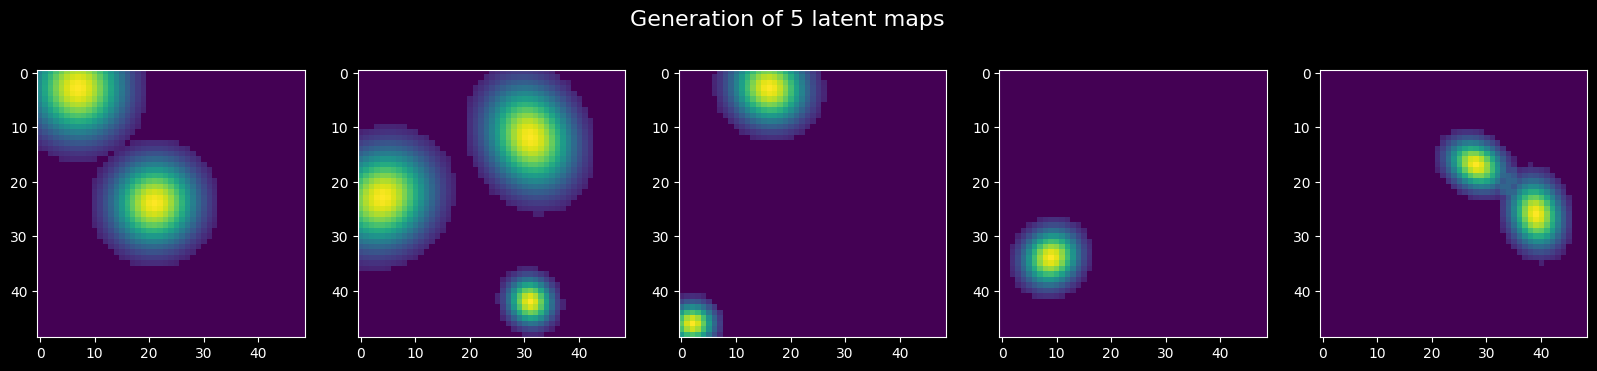

In [91]:
fig, ax = plt.subplots(1,k, figsize=(20, 4))
fig.suptitle('Generation of 5 latent maps',fontsize=16)
for i in range(k):
    ax[i].imshow(latent_global_maps[i, :,:])
fig.show()

In [92]:
np.save('real_v_maps', latent_global_maps)

<h3><u>b- Subject level latent spatial map</u><h3>

<span style="font-size: 17px;">  In addition, we generate subject-speciﬁc latent spatial maps by adding an isotropic, Gaussian-distributed, jitter on the blobs position and width.</span>


In [93]:
def get_subject_blobs(all_blobs: List[List[Blob]], jitter: float = 0, smoothness: float = 0) -> List[List[Blob]]:
    """ 
    Modifies and returns a list of blob lists, representing subject-specific blobs
    based on global blob characteristics, applying jitter and smoothness adjustments.
    
    Args:
    - all_blobs: A list of lists containing Blob objects.
    - jitter: The standard deviation of the normal distribution for center jitter.
    - smoothness: The standard deviation of the normal distribution for blob radius adjustment.
    
    Returns:
    - A list of lists containing adjusted Blob objects for a specific subject.
    """
    all_subject_blobs = []

    for blob_list in all_blobs:
        subject_blob_list = []

        for blob in blob_list:
            subject_blob = blob.get_copy()
            noise_on_width = np.random.normal(loc=0, scale=smoothness)
            new_radius = subject_blob.radius + noise_on_width

            if new_radius < 0:
                print(f"Avertissement : rayon négatif détecté, fixé à 0. Rayon initial : {subject_blob.radius}, Bruit : {noise_on_width}")
                new_radius = 0  # Fixer le rayon à zéro s'il est négatif

            subject_blob.radius = new_radius
            center_shift = np.random.normal(loc=0, scale=jitter, size=2).astype(int)
            new_center = np.clip(subject_blob.center + center_shift, 0, subject_blob.grid_length - 1)  # -1 si la longueur de la grille est la limite maximale

            # Si le centre est déplacé en dehors des limites de la grille, imprimer un avertissement
            if (new_center < 0).any() or (new_center >= subject_blob.grid_length).any():
                print(f"Avertissement : déplacement du centre hors des limites. Centre initial : {subject_blob.center}, Déplacement : {center_shift}")

            subject_blob.center = new_center
            subject_blob_list.append(subject_blob)

        all_subject_blobs.append(subject_blob_list)

    return all_subject_blobs

def get_latent_subject_maps_from_blobs(subject_blobs: List[List[Blob]], grid_length: int = 50) -> np.ndarray:
    """
    Generates latent subject maps from the list of the subject's blobs.
    
    """
    k = len(subject_blobs)
    latent_subject_maps = []
    for numMap in range(k):
        latent_subject_maps.append(generate_global_map(grid_length=grid_length, blobs=subject_blobs[numMap]))
    latent_subject_maps = np.array(latent_subject_maps)
    
    return latent_subject_maps


In [94]:
def create_subjects_latent_maps(all_blobs:List[List[Blob]], nbSubjects: int, jitter:int = 3, smoothness: int= 2, grid_length:int = 50):
    """This function takes a global set of blobs and generates individual latent maps for a given number of subjects.
    Each subject's maps are generated by applying jitter and smoothness to the blobs, which simulates individual variability.
    
    Args:
    - all_blobs: A list of lists containing Blob objects for each latent map.
    - nbSubjects: Number of subjects.
    - jitter: The standard deviation of the Gaussian noise added to the position of each blob to simulate jitter (default is 3).
    - smoothness: The standard deviation of the Gaussian noise added to the size of each blob to simulate smoothness (default is 2).
    
    """
    maps_from_subjects = []
    for num_subject in range(nbSubjects):
        subject_blobs = get_subject_blobs(all_blobs, jitter, smoothness)
        latent_subject_maps = get_latent_subject_maps_from_blobs(subject_blobs, grid_length=grid_length)
        maps_from_subjects.append(latent_subject_maps)
    return maps_from_subjects



In [95]:
# returns the list containing latent maps array (size (5,50,50)) for each subject
nbSubjects = 4
jitter = 3
smoothness= 2
maps_per_subject = create_subjects_latent_maps(all_blobs, nbSubjects = nbSubjects, jitter = jitter, smoothness= smoothness, grid_length=grid_length)

/var/folders/9k/c2_qmgms5bv_gzkb9tf_tc1w0000gn/T/ipykernel_6964/502577363.py:6: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


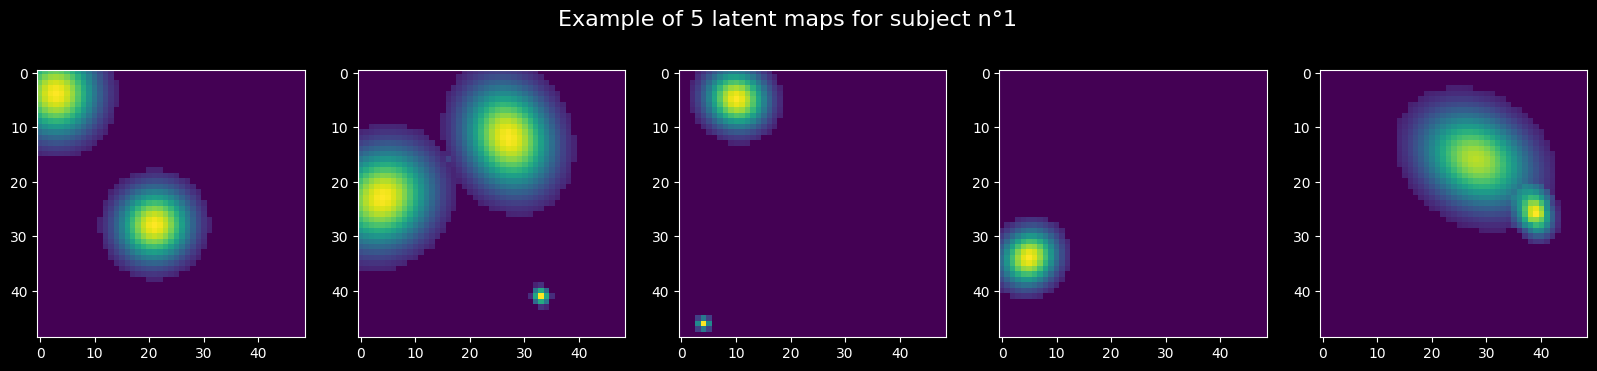

In [96]:
# Plotting the 5 latents maps generated 
fig, ax = plt.subplots(1,k, figsize=(20, 4))
fig.suptitle('Example of 5 latent maps for subject n°1',fontsize=16)
for i in range(k):
    ax[i].imshow(maps_per_subject[0][i, :,:])
fig.show()


<h3><u>c- Generation of synthetic fmri data </u><h3>

<span style="font-size: 17px;">  From these maps, we generate observations by mixing them with random time series and adding random spatially-correlated Gaussian noise.</span>

In [97]:
def generate_synthetic_fmri_data(n, maps_per_subjects:List[np.ndarray], sigma_space = 2, correlation_scale=0.3, sigma_ts=4):
    """Generates synthetic fMRI data for a group of subjects.

    This function simulates fMRI data by creating spatially correlated noise and combining it
    with subject-specific latent maps, which represent underlying brain activation patterns. 

    Args:
    - n (int): Number of time points
    - maps_per_subjects (List[np.ndarray]): A list containing arrays (k, grid_length, grid_length) for each subject .
    - sigma_space (float, optional): The standard deviation of the Gaussian noise added to each observation. Default is 2
    _ sigma_ts (float, optional): The standard deviation of the random time series mixed with the spatial components. Default is 4
    - correlation_scale (float, optional): The scale of correlation for the spatially correlated noise. Default is 0.5.

    Returns:
    - np.ndarray: A 4D numpy array of shape (nbSubjects, n, grid_length, grid_length) containing the generated synthetic fMRI data.
    """
    
    nbSubjects = len(maps_per_subjects)
    k, grid_length, _ = maps_per_subject[0].shape
    
    data = np.zeros((nbSubjects, n, grid_length**2))

    for subject_idx in range(nbSubjects):
        subject_latent_maps = maps_per_subject[subject_idx] #of shape (k, grid_length, grid_length)
        
        subject_latent_vector = subject_latent_maps.reshape(k, grid_length**2) #careful: V_S.T in the article
        U_s = np.random.normal(loc=0, scale=sigma_ts, size=(n, k))

        spatial_noise = get_random_spatially_correlated_noise(grid_length=grid_length, sigma_final= sigma_space, correlation_scale= correlation_scale ).reshape(grid_length**2)
        observations = U_s @ subject_latent_vector + spatial_noise
        data[subject_idx] = observations

    return data.reshape(nbSubjects, n, grid_length, grid_length)

2.0

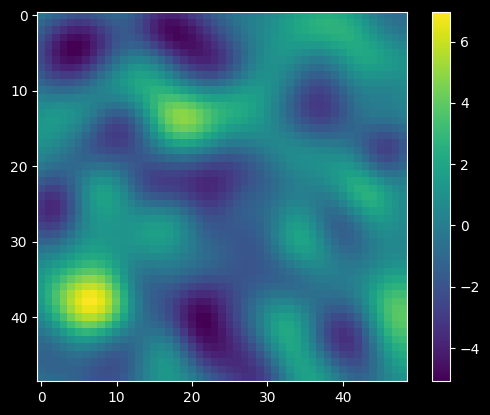

In [98]:
# Random spatially-correlated Gaussian noise representation
spatial_noise = get_random_spatially_correlated_noise(grid_length=grid_length, sigma= 3, correlation_scale= 0.2, sigma_final=2)
plt.imshow(spatial_noise)
plt.colorbar()

spatial_noise.std()

In [99]:
# Parameters
time_points = 149
sigma_space = 0.5
sigma_space = 0.5
sigma_ts=4

# Generate synthetic fMRI data
synthetic_data = generate_synthetic_fmri_data(n = time_points, maps_per_subjects = maps_per_subject,sigma_space = 2, correlation_scale=0.3, sigma_ts=4)
synthetic_data.shape

(4, 149, 49, 49)

/var/folders/9k/c2_qmgms5bv_gzkb9tf_tc1w0000gn/T/ipykernel_6964/120280513.py:6: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


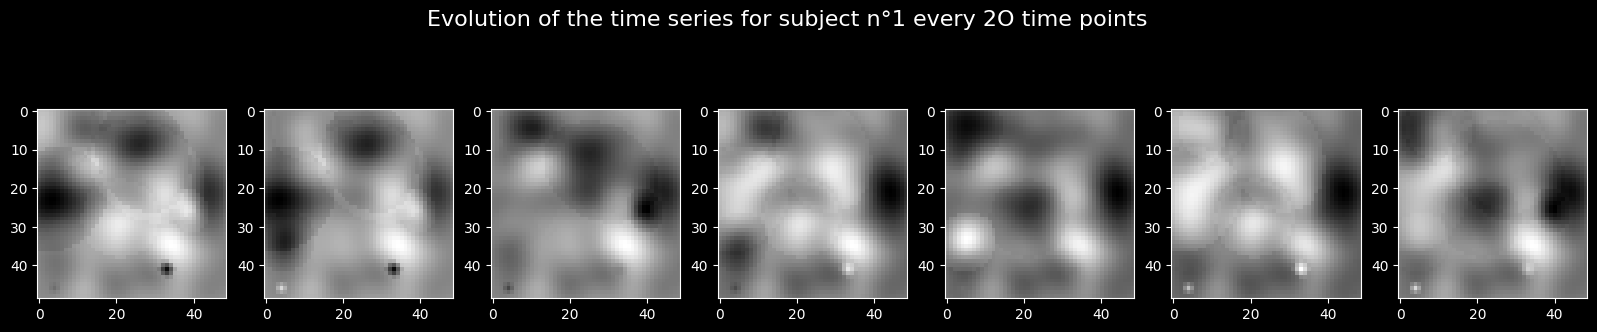

In [100]:
# Plotting the 5 latents maps generated 
fig, ax = plt.subplots(1, 7, figsize=(20, 4))
fig.suptitle('Evolution of the time series for subject n°1 every 2O time points',fontsize=16)
for i in range(7):
    ax[i].imshow(synthetic_data[0, 20*i, :, : ], cmap='gray')
fig.show()


In [101]:
data_fmri_path = "synthetic_data_prime"
np.save(data_fmri_path , synthetic_data)

synthetic_data.shape

(4, 149, 49, 49)

<h2><u>2- Model </u><h2>



We consider a dataset of brain signal time series of length $n$ for $S$ subjects, measured on $p$ voxels: $\{Y_s \in \mathbb{R}^{n \times p}, s = 1 \ldots S\}$. We stipulate that the corresponding 3D images are the observation of $k$ spatial latent factors $V_s \in \mathbb{R}^{p \times k}$, that characterize functional processes or structured measurement artifacts, and associated time series $U_s \in \mathbb{R}^{n \times k}$: $Y_s \approx U_sV_s^\top$. 


In the case of a multi-subject dataset, we give a hierarchical probabilistic model for dictionary learning. 

\begin{equation}
\forall s \in \{1 \ldots S\}, Y_s = U_sV_s^\top + E_s, E_s \sim \mathcal{N}(0,\sigma I), U_s \sim \mathcal{N}(0,\Sigma_U)
\end{equation}

In addition, the subject-specific maps $V_s$ are generated from population-level latent factors, the spatial patterns written as brain maps $V$:

\begin{equation}
\forall s \in \{1 \ldots S\}, V_s = V + F_s, F_s \sim \mathcal{N}(0,\zeta I)
\end{equation}

The optimal dictionary elements and loading factors are obtained by minimizing the energy function:

\begin{equation}
(U_s, V_s)_{s \in \{1 \ldots S\}}, V = \arg\min E(U_s, V_s, V), \text{ s.t. } \|u_{sl}\|_2 \leq 1
\end{equation}

where $E(U_s,V_s,V)$ is given by:

\begin{equation}
E(U_s,V_s,V) = \sum_{s=1}^S \frac{1}{2} \left\|Y_s - U_sV_s^\top \right\|_{\text{Fro}}^2 + \mu \left\|V_s - V \right\|_{\text{Fro}}^2 + \lambda \Omega(V),
\end{equation}

and the regularization term $\Omega_{SL}(v)$ is defined as:

\begin{equation}
\Omega_{SL}(v) = \|v\|_1 + \frac{1}{2}v^\top L v
\end{equation}



In [102]:
def get_init_V(data_fmri: np.ndarray, n_components: int) -> np.ndarray:
    S, n, p1, _ = data_fmri.shape
    X = data_fmri.reshape(S*n, p1, p1)
    X = X.reshape(S*n, p1 * p1) #in 2 steps in case it causes problems
    ica_estimator = FastICA(
                    n_components=n_components, max_iter=400, whiten="arbitrary-variance", tol=15e-5)
    ica_estimator.fit(X)

    components = ica_estimator.components_[:n_components]
    
    return components

def plot_latent_maps(V: np.ndarray, n_components) -> None:
    fig, ax = plt.subplots(1, n_components, figsize=(20, 4))
    fig.suptitle(f'Initialization of the {n_components} latent maps', fontsize=16)
    for i in range(n_components):
        ax[i].imshow(V[i, :,:], cmap="inferno")
    fig.show()

def read_fmri(path: str) -> np.ndarray:
    data_fmri = np.load(path)
    S,n,_,_ = data_fmri.shape
    Ys = data_fmri.reshape(S, n, -1) # need to be of shape (S,n,p)
    return Ys


V = get_init_V(synthetic_data , n_components = k)
print(V.shape)

Ys = synthetic_data.reshape(nbSubjects, time_points, -1)
Ys.shape


(5, 2401)


(4, 149, 2401)

In [103]:
class MDSLModel:
    def __init__(self, grid_length: int = 50, k: int = 5, mu: float = 0.1, lambd: float= 0.1) -> None:
        self.grid_length = grid_length
        self.L = MDSLModel.create_2d_laplacian(grid_length)
        self.k = k 
        self.mu = mu
        self.lambd = lambd

    @staticmethod
    def create_2d_laplacian(grid_length: int):
        # Création de la matrice laplacienne pour une grille 1D
        e = np.ones(grid_length)
        laplacian_1d = np.diag(2 * np.ones(grid_length)) - np.diag(np.ones(grid_length - 1), k=1) - np.diag(np.ones(grid_length - 1), k=-1)
        
        # Création de la matrice laplacienne pour une grille 2D
        I = np.eye(grid_length)
        laplace_2d = np.kron(I, laplacian_1d) + np.kron(laplacian_1d, I)
        return laplace_2d
    
    #deprecated
    def regularizer(self, V: np.ndarray):
        _, k = V.shape
        norm1_v = np.sum(np.abs(V))
        quadratic_term = 0
        for i in range(k):
            quadratic_term += 0.5 * (V[:, i].T @ self.L @ V[:, i])
        return norm1_v + quadratic_term
    
    def omega(self, v_grid):
        """
        returns omega(v) where v is a np array of size p1*p2
        """
        norm1_v = np.sum(np.abs(v_grid))

        lv = laplacian_grid(v_grid)
        vT_lv = np.sum(v_grid * lv)
        
        return norm1_v + 1/2 * vT_lv
    
    def omega_v_vector(self, V):
        """ 
        V is of shape (grid_length*grid_length, k) with k number of components
        """
        p_squared, k = V.shape
        p = int(np.sqrt(p_squared))
        omega_summed = 0
        for num_component in range(k):
            omega_summed += omega(V[:, num_component].reshape(p, p))
        
        return omega_summed

    def compute_energy(self, Ys, Us, Vs, V):
        S = len(Us)  # Number of subjects
        energy = 0
        for s in range(S):
            term1 = np.linalg.norm(Ys[s] - Us[s] @ Vs[s].T, 'fro')**2
            term2 = self.mu * np.linalg.norm(Vs[s] - V, 'fro')**2
            energy += 0.5 * (term1 + term2)
        #regularization_term = self.regularizer(V)
        regularization_term = self.omega_v_vector(V)
        energy += self.lambd * regularization_term
        return energy

    def update_vs(self, V, us, ys):
        id_matrix = np.identity(us.shape[1])
        vs = V + (ys - us @ V.T).T @ us @ np.linalg.inv(us.T @ us + self.mu * id_matrix)
        return vs

    def update_us(self, ys, vs, us):
        for l in range(self.k):
            u_l, v_l = us[:, l], vs[:, l]
            u_l_new = u_l + np.linalg.norm(v_l, 2)**-2 * (ys - us @ vs.T) @ v_l
            us[:, l] = u_l_new / max(np.linalg.norm(u_l_new, 2), 1)
        return us
    
    @staticmethod
    def soft_thresholding(x, lambd):
        """Element-wise soft-thresholding operator."""
        return np.sign(x) * np.maximum(np.abs(x) - lambd, 0)
        
    def smooth_lasso_prox(self, v: np.ndarray, gamma: float, kappa: float, m: int = 100):
        v_star = copy.deepcopy(v)
        z = copy.deepcopy(v_star)
        tau = 1
        p_squared = z.shape
        p = int(np.sqrt(p_squared))
        
        for l in range(m):
            v0 = v_star.copy()
            # Soft-thresholding operation
            #v_star = MDSLModel.soft_thresholding(z - kappa * (z - v + gamma * self.L @ z), kappa * gamma)
            v_star = MDSLModel.soft_thresholding(z - kappa * (z - v - gamma * laplacian_grid(z.reshape(p, p)).reshape(p**2)), kappa * gamma)
            tau_0 = tau
            tau = (1 + np.sqrt(1 + 4 * tau ** 2)) / 2
            z = v_star + ((tau_0 - 1) / tau) * (v_star - v0)
        return v_star

    def __call__(self,
                 Ys: np.ndarray,
                 V: np.ndarray,
                 gamma: float = 0.1,
                 kappa: float = 0.1,
                 max_iter=30,
                 tolerance: float =1e-4):
        """_summary_

        Args:
            Ys (np.ndarray): _description_
            V (np.ndarray): _description_
            gamma (np.ndarray): _description_
            kappa (np.ndarray): _description_
            max_iter (int, optional): _description_. Defaults to 1000.
            tolerance (float, optional): _description_. Defaults to 1e-4.

        Returns:
            _type_: _description_
        """
        n, p = Ys.shape[1:]  # n number of time points, p number of voxels 
        S = len(Ys)          # S number of subjects
        Vs = [np.random.rand(p, self.k) for _ in range(S)]  # Subject specific spatial maps
        Us = [np.random.rand(n, self.k) for _ in range(S)]  # Time series
        E_old = self.compute_energy(Ys, Us, Vs, V) * 2 # *2 ? j'ai mis au pif faut faire le calcul pour rentrer dans la boucle
        E_new = self.compute_energy(Ys, Us, Vs, V)

        i = 0  # Iteration counter
        print(f'Iteration : {i} Energy: {E_new}')
        while np.abs(E_new - E_old) > tolerance * E_old and i < max_iter:
            E_old = E_new
            # Update each U^s
            for s in range(S):
                Us[s] = self.update_us(Ys[s], Vs[s], Us[s])
                Vs[s] = self.update_vs(V, Us[s], Ys[s])

            Vs_mean = np.mean(Vs, axis=0)
            # Apply the proximal operator to the mean of every subject spatial maps
            for j in range(self.k):
                V[:, j] = self.smooth_lasso_prox(v = Vs_mean[:, j], gamma = gamma, kappa = kappa)
            
            # Compute the energy
            E_new = self.compute_energy(Ys, Us, Vs, V)
            i += 1
        
            print(f'Iteration : {i} Energy: {E_new}')
        
        return V, Vs, Us

In [113]:
model = MDSLModel(k= k,grid_length = grid_length)
V_pred, Vs_pred, Us_pred = model(Ys= Ys , V=V.reshape(grid_length**2,k), gamma= 0.1 , kappa=0.1, max_iter=100,  tolerance=1e-4)

Iteration : 0 Energy: 6783711.221950277


/var/folders/9k/c2_qmgms5bv_gzkb9tf_tc1w0000gn/T/ipykernel_6964/445920139.py:86: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  p = int(np.sqrt(p_squared))


Iteration : 1 Energy: 2123653.575758254
Iteration : 2 Energy: 1025674.128532432
Iteration : 3 Energy: 652923.8692028016
Iteration : 4 Energy: 568976.4461657179
Iteration : 5 Energy: 527182.2811125193
Iteration : 6 Energy: 494674.2347183791
Iteration : 7 Energy: 463687.4958946889
Iteration : 8 Energy: 436826.55302560405
Iteration : 9 Energy: 418544.7841670149
Iteration : 10 Energy: 406688.78339069645
Iteration : 11 Energy: 398263.7650732746
Iteration : 12 Energy: 391749.80632227653
Iteration : 13 Energy: 386453.10017554223
Iteration : 14 Energy: 382002.8423142234
Iteration : 15 Energy: 378165.0188098772
Iteration : 16 Energy: 374777.8864465135
Iteration : 17 Energy: 371727.7180590042
Iteration : 18 Energy: 368933.0889379176
Iteration : 19 Energy: 366337.23135489534
Iteration : 20 Energy: 363899.3071665559
Iteration : 21 Energy: 361590.8777404754
Iteration : 22 Energy: 359391.8384294976
Iteration : 23 Energy: 357288.34237386886
Iteration : 24 Energy: 355270.6082690549
Iteration : 25 Ener

In [87]:
np.save("predicted_v_maps_jean", V_pred)

<h3><u>2- Predicted time series analysis  </u><h3>


#### We want to see if the predicted time series for each subject fits our initial ones

/var/folders/9k/c2_qmgms5bv_gzkb9tf_tc1w0000gn/T/ipykernel_6964/177076759.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


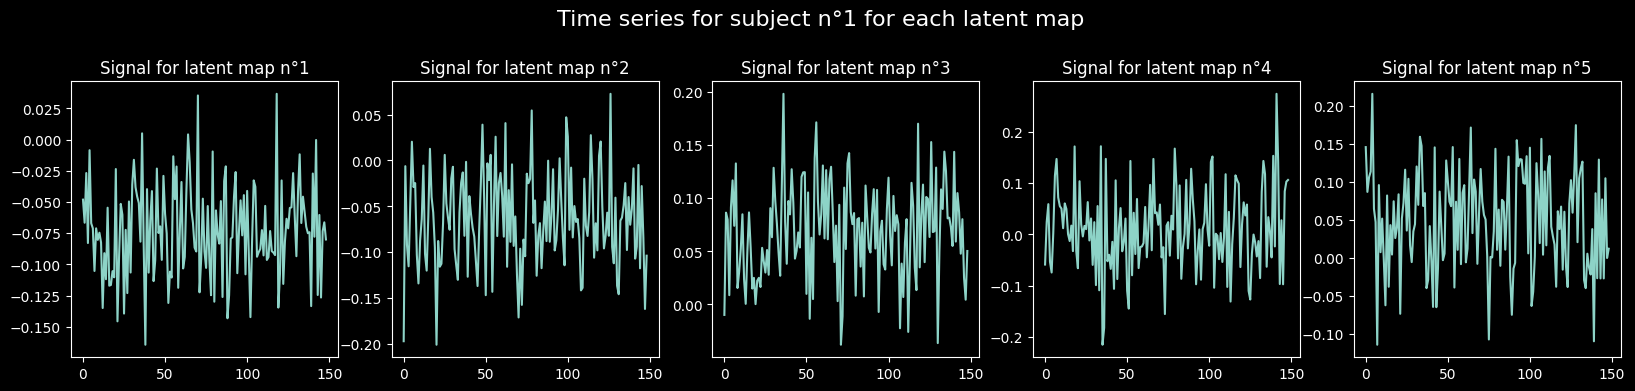

In [114]:
# Plot the time series Us
fig, ax = plt.subplots(1, k, figsize=(20, 4))
fig.suptitle('Time series for subject n°1 for each latent map',fontsize=16) 
fig.subplots_adjust(top=0.8)

for i in range(k):
    # add a title on each subplot
    ax[i].set_title(f'Signal for latent map n°{i+1}')
    ax[i].plot(Us_pred[0][:, i])
fig.show()  


In [115]:
def autocorrelation(signal):
    n = len(signal)
    mean = np.mean(signal)
    autocorr = scipy.signal.correlate(signal - mean, signal - mean, mode="full")
    return autocorr[n:n+n//2]


/var/folders/9k/c2_qmgms5bv_gzkb9tf_tc1w0000gn/T/ipykernel_6964/3772555013.py:13: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


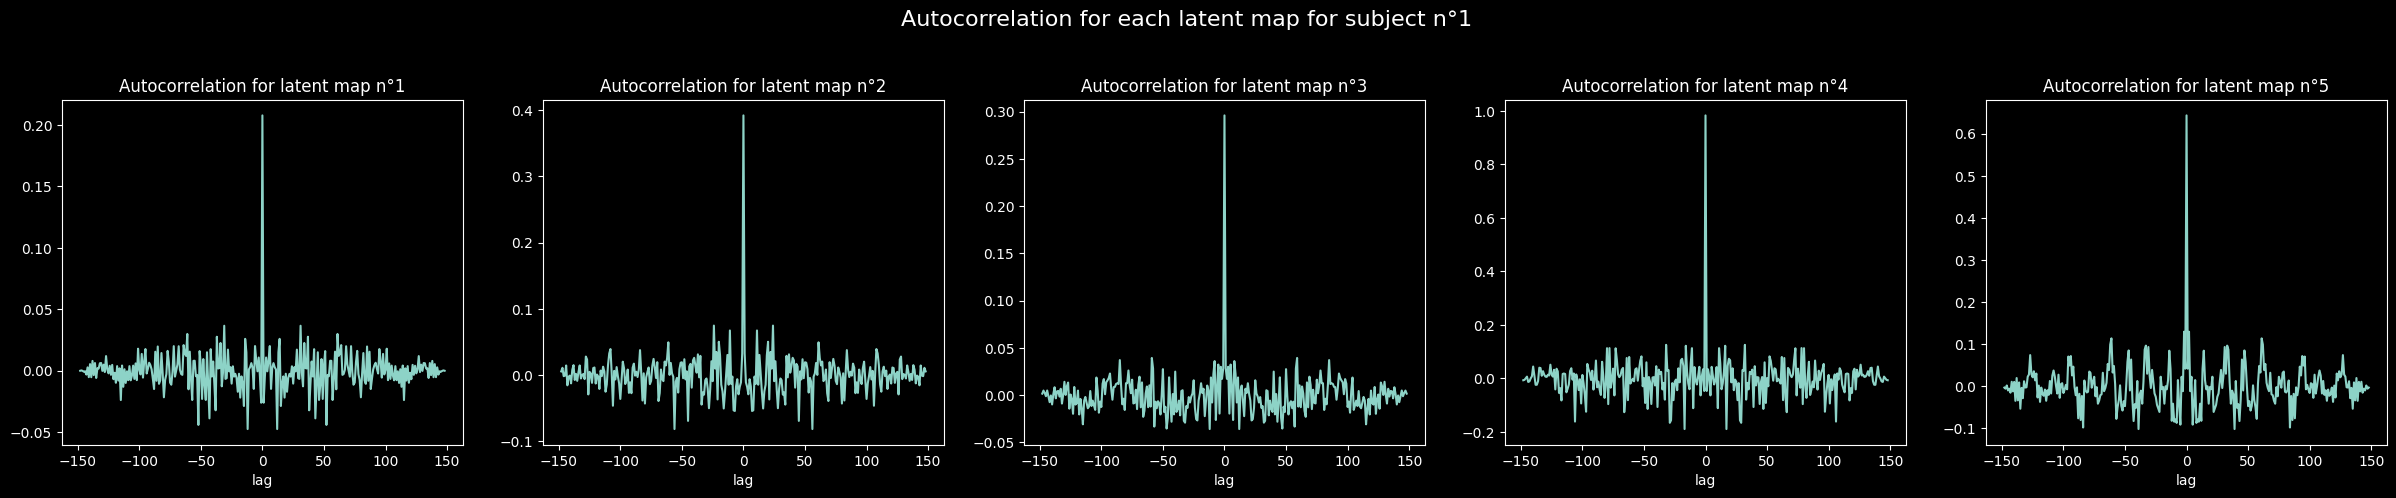

In [116]:
fig, ax = plt.subplots(1, k, figsize=(30, 5))               
fig.suptitle('Autocorrelation for each latent map for subject n°1',fontsize=16)
fig.subplots_adjust(top=0.8)

for i in range(k):
    ax[i].set_title(f'Autocorrelation for latent map n°{i+1}')
    U_s_i = Us_pred[0][:, i] 
    U_s_i = (U_s_i-U_s_i.mean())
    autocorr = scipy.signal.correlate(U_s_i, U_s_i, mode="full")
    lags = scipy.signal.correlation_lags(len(U_s_i), len(U_s_i))
    ax[i].plot(lags, autocorr)
    ax[i].set_xlabel("lag")
fig.show()



<h3><u>3- Comparison with others models </u><h3>

In [117]:
from  sklearn.decomposition import SparsePCA, FastICA

def SPCA(data: np.ndarray, n_components: int)-> np.ndarray:
    S,n,p1,_ = data.shape
    transformer = SparsePCA(n_components=n_components, alpha=0.3, ridge_alpha=0.01, max_iter=1000, tol=1e-5)
    X = data.reshape(S*n, p1*p1)
    transformer.fit(X)
    components = transformer.components_[:n_components]
    return components
    
def ICA(data: np.ndarray, n_components: int) -> np.ndarray:
    S, n, p1, _ = data.shape
    X = data.reshape(S*n, p1* p1)
    ica_estimator = FastICA(n_components=n_components, max_iter=400, whiten="arbitrary-variance", tol=15e-5)
    ica_estimator.fit(X)
    components = ica_estimator.components_[:n_components]
    
    return components


ICA_maps = ICA(data=synthetic_data, n_components=5)
#SPCA_maps = SPCA(data=synthetic_data, n_components=5)
SPCA_maps = ICA_maps

In [120]:
V_pred.shape

(2401, 5)

In [121]:
V_pred_reordered = reorder_maps(latent_global_maps, V_pred.transpose(1,0).reshape(5, 49, 49))
ICA_maps_reordered = reorder_maps(latent_global_maps, ICA_maps.reshape(5, 49, 49))
SPCA_maps_reordered = reorder_maps(latent_global_maps, ICA_maps.reshape(5, 49, 49))


/var/folders/9k/c2_qmgms5bv_gzkb9tf_tc1w0000gn/T/ipykernel_6964/434094229.py:17: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


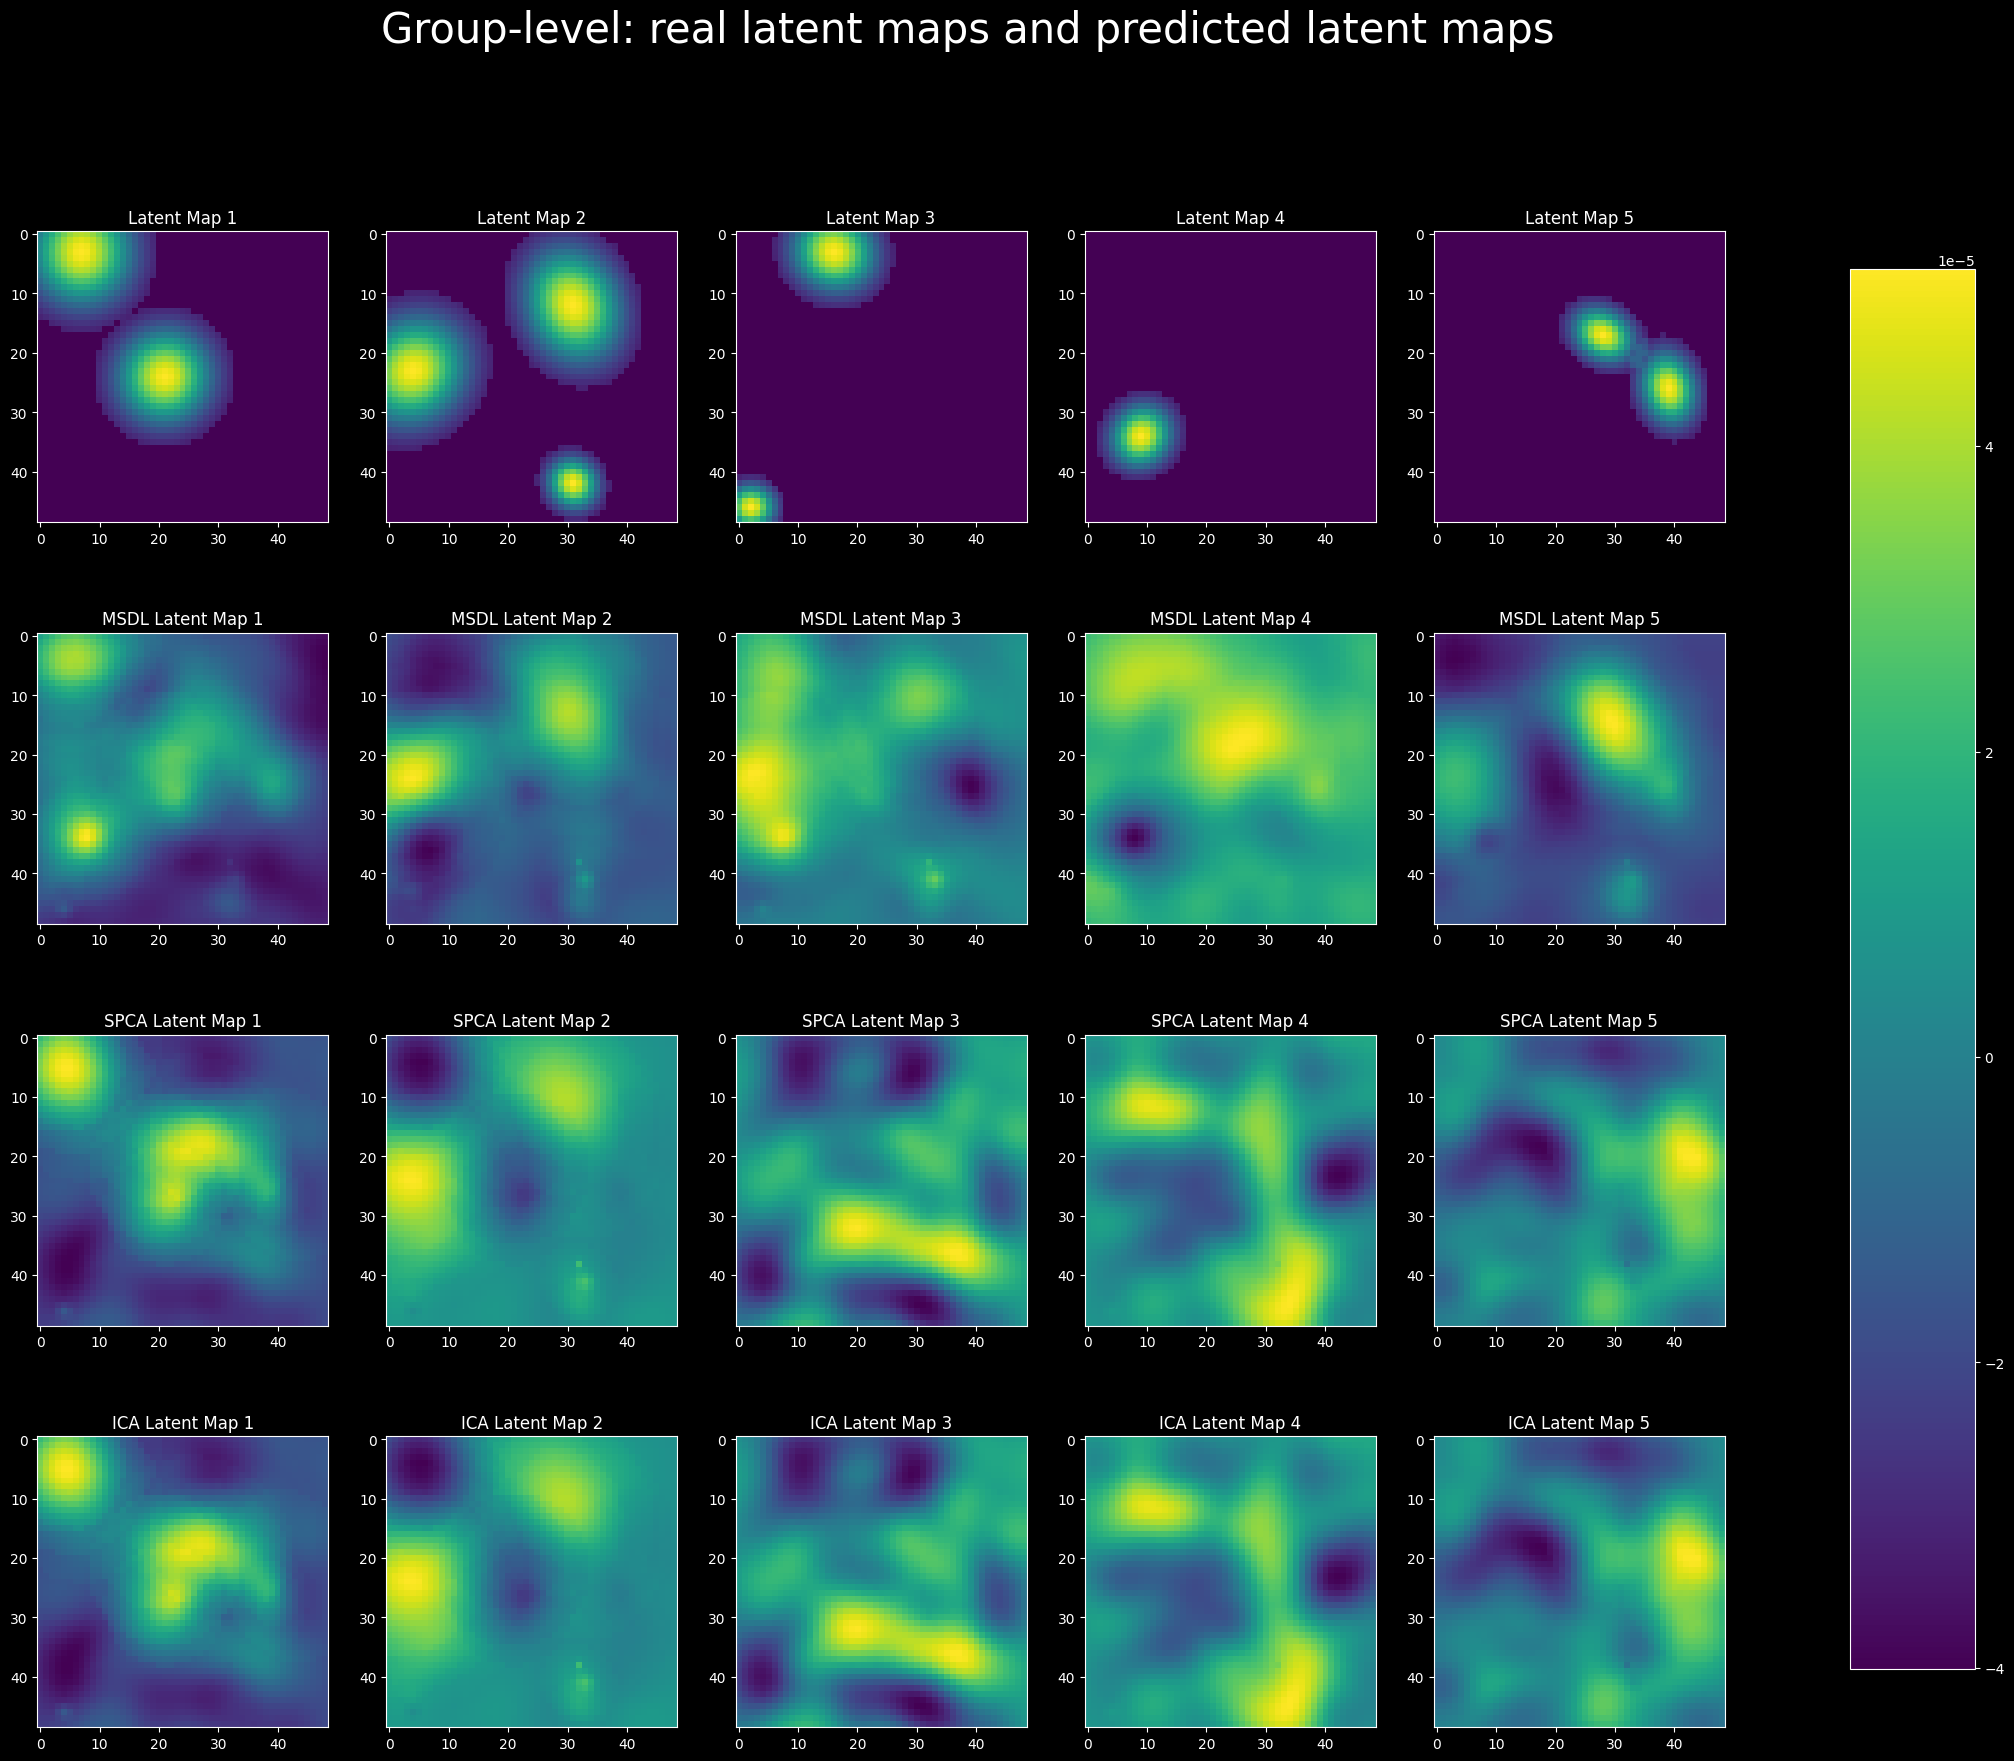

In [123]:
fig, ax = plt.subplots(4, k, figsize=(25, 20))
fig.suptitle(f'Group-level: real latent maps and predicted latent maps ', fontsize=30)

for i in range(k):
    im = ax[0,i].imshow(latent_global_maps[i])
    im = ax[1,i].imshow(V_pred_reordered[i].reshape(grid_length,grid_length))
    im = ax[2,i].imshow(ICA_maps_reordered[i].reshape(grid_length,grid_length))
    im = ax[3,i].imshow(SPCA_maps_reordered[i].reshape(grid_length,grid_length))
    ax[0,i].set_title(f'Latent Map {i+1}')
    ax[1,i].set_title(f'MSDL Latent Map {i+1}')
    ax[2,i].set_title(f'SPCA Latent Map {i+1}')
    ax[3,i].set_title(f'ICA Latent Map {i+1}')
    
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
fig.show()


<h2><u>3- Evaluation </u><h2>

<h3><u>1- Choice of parameters </u><h3>

#### Choice for  the subject level penalization $\mu$, the population level penalization $\lambda$ and model order $k$
- We compute $\mu$ using the variance intra-subject $\sigma$ and the variance inter-subject $\zeta$

In [112]:
import numpy as np

def compute_likelihood(Ys, Vs, Sigma_U, sigma):
    n = Ys.shape[0]
    
    # Compute variance of the model
    Sigma_model = Vs @ Sigma_U @ Vs.T + sigma * np.identity(Vs.shape[1])
    
    # Compute the log determinant of sigma_model
    log_det_Sigma_model = np.linalg.slogdet(Sigma_model)[1]
    
    # Compute the trace term in the likelihood
    inv_Sigma_model = np.linalg.inv(Sigma_model)
    trace_term = np.trace(Ys @ inv_Sigma_model @ Ys.T)
    
    # Compute the likelihood
    likelihood = -0.5 * log_det_Sigma_model - (1/(2*n)) * trace_term 
    
    return likelihood

<h3><u>2- Correlations between recovered maps and individual maps </u><h3>

In [27]:
import numpy as np
from tqdm import tqdm

def cross_correlation(map1, map2):
    """Calculate the cross-correlation coefficient between two maps."""
    correlation_matrix = np.corrcoef(map1.ravel(), map2.ravel())
    return correlation_matrix[0, 1]

def average_cross_correlation(maps, dataset, method='MSDL', mode="population"):
    # maps must : {population_maps: np.array (k,), subject_maps: np.array}
    """Calculate the average cross-correlation between sets of maps and a dataset."""
    correlations = []
    # if population mode, we compare the  population predicted maps to the population maps
    if mode == 'population':
        correlations = [cross_correlation(dataset['population_maps'][i], maps['population_maps'][i].reshape(grid_length,grid_length)) for i in range(len(maps))]
    # if subject mode, we compare the population predicted maps (for ICA and SPCA) and subject predicted maps for MSDL, to the subject maps
    elif mode == 'subject':
        for i in range(len(dataset['subject_maps'])):
            for j in range(len(dataset['subject_maps'][i])):
                target_map = dataset['subject_maps'][i][j]
                predicted_map = maps['subject_maps'][i][j].reshape(grid_length,grid_length) if method == 'MSDL' else maps['population_maps'][j]
                corr = cross_correlation(target_map, predicted_map)
                correlations.append(corr)
    return np.mean(correlations)

def create_datasets(parameters, all_blobs, latent_global_maps, nbSubjects, grid_length, k, time_points):
    """Generate synthetic datasets based on provided parameters."""
    datasets = []
    for jitter, smoothness in parameters:
        maps_per_subject = create_subjects_latent_maps(all_blobs, nbSubjects=nbSubjects, jitter=jitter, smoothness=smoothness, grid_length=grid_length)
        synthetic_data = generate_synthetic_fmri_data(n=time_points, maps_per_subjects=maps_per_subject) 
        datasets.append({
            "synthetic_data": synthetic_data, # of shape (nbSubjects, n, grid_length, grid_length)
            "subject_maps": maps_per_subject,   # of shape (nbSubjects, k, grid_length, grid_length)
            "population_maps": latent_global_maps   # of shape (k, grid_length, grid_length)
        })
    return datasets

def MSDL(model, data, n_components):
    """Compute MSDL maps for a given dataset."""
    Ys = data.reshape(nbSubjects, time_points, -1)
    V = get_init_V(data, n_components=n_components).reshape(grid_length**2,k)
    V_pred, Vs, _ = model(Ys=Ys ,V = V)
    V_pred = V_pred.transpose((1, 0))
    Vs = [v.transpose((1, 0)) for v in Vs]
    return V_pred, Vs

In [28]:
parameters = [(0,0),(3,0),(0,2),(3,2)]
datasets = create_datasets(parameters, all_blobs, latent_global_maps, nbSubjects, grid_length, k, time_points)

In [69]:

all_maps = {"ICA_maps":[],"SPCA_maps":[],"MSDL_maps":[]}
for dataset in tqdm(datasets):
    all_maps["ICA_maps"].append({"population_maps":ICA(data=dataset["synthetic_data"], n_components=k)}) # ICA maps are the s<wxcdsqaze hape (k,grid_length**2)
    #all_maps["SPCA_maps"].append({"population_maps":SPCA(data=dataset["synthetic_data"], n_components=k)})# SPCA maps are the shape (k,grid_length**2)
    MSDL_maps = MSDL(model, dataset["synthetic_data"], n_components=k)
    all_maps["MSDL_maps"].append({"population_maps":MSDL_maps[0] , "subject_maps": MSDL_maps[1]}) # MSDL maps are the shape (k,grid_length**2) for the population and (nbSubjects,k,grid_length**2) for the subjects


  0%|          | 0/4 [00:00<?, ?it/s]

Iteration : 0 Energy: 6440566.045994875
Iteration : 1 Energy: 1615911.9481353152


/var/folders/9k/c2_qmgms5bv_gzkb9tf_tc1w0000gn/T/ipykernel_6964/445920139.py:86: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  p = int(np.sqrt(p_squared))


Iteration : 2 Energy: 701696.9428392927
Iteration : 3 Energy: 526533.089242659
Iteration : 4 Energy: 430352.707160431
Iteration : 5 Energy: 392202.84887441073
Iteration : 6 Energy: 369282.9645210155
Iteration : 7 Energy: 352086.9106937545
Iteration : 8 Energy: 337750.4762985527
Iteration : 9 Energy: 325670.39180381317
Iteration : 10 Energy: 315690.95159265446
Iteration : 11 Energy: 307704.81623470044
Iteration : 12 Energy: 301396.49917513225
Iteration : 13 Energy: 296323.16869819607
Iteration : 14 Energy: 292094.905166552
Iteration : 15 Energy: 288439.67614162515
Iteration : 16 Energy: 285185.40639938664
Iteration : 17 Energy: 282225.7722695754
Iteration : 18 Energy: 279495.377832718
Iteration : 19 Energy: 276952.46694123966
Iteration : 20 Energy: 274569.4646692913
Iteration : 21 Energy: 272328.2054492856
Iteration : 22 Energy: 270215.74433912855
Iteration : 23 Energy: 268223.00823055545
Iteration : 24 Energy: 266343.6328573947
Iteration : 25 Energy: 264572.7566856344
Iteration : 26 En

 25%|██▌       | 1/4 [00:09<00:27,  9.03s/it]

Iteration : 30 Energy: 257232.89098852137
Iteration : 0 Energy: 7576744.700891862
Iteration : 1 Energy: 1724339.3582115874


/var/folders/9k/c2_qmgms5bv_gzkb9tf_tc1w0000gn/T/ipykernel_6964/445920139.py:86: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  p = int(np.sqrt(p_squared))


Iteration : 2 Energy: 811264.8268408498
Iteration : 3 Energy: 561359.6288451211
Iteration : 4 Energy: 418704.8885539204
Iteration : 5 Energy: 355168.06505983684
Iteration : 6 Energy: 332216.00473233213
Iteration : 7 Energy: 318136.72595347493
Iteration : 8 Energy: 308302.59779331175
Iteration : 9 Energy: 300843.0231808203
Iteration : 10 Energy: 294863.6791385962
Iteration : 11 Energy: 289949.34417392407
Iteration : 12 Energy: 285837.77113134693
Iteration : 13 Energy: 282349.80078052316
Iteration : 14 Energy: 279357.43601327675
Iteration : 15 Energy: 276765.7450167346
Iteration : 16 Energy: 274502.88372803485
Iteration : 17 Energy: 272513.3494647007
Iteration : 18 Energy: 270753.51250366034
Iteration : 19 Energy: 269188.88005287107
Iteration : 20 Energy: 267791.8591017962
Iteration : 21 Energy: 266540.00886678515
Iteration : 22 Energy: 265414.67054560676
Iteration : 23 Energy: 264400.4391086751
Iteration : 24 Energy: 263484.4055040033
Iteration : 25 Energy: 262655.5688417787
Iteration :

 50%|█████     | 2/4 [00:16<00:15,  7.97s/it]

Iteration : 29 Energy: 260038.2782639078
Iteration : 30 Energy: 259523.98098362272
Iteration : 0 Energy: 7480208.385433899
Iteration : 1 Energy: 1684693.992224614


/var/folders/9k/c2_qmgms5bv_gzkb9tf_tc1w0000gn/T/ipykernel_6964/445920139.py:86: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  p = int(np.sqrt(p_squared))


Iteration : 2 Energy: 834391.290198036
Iteration : 3 Energy: 508957.1655129785
Iteration : 4 Energy: 405468.304864075
Iteration : 5 Energy: 363751.11935213953
Iteration : 6 Energy: 345832.04255774734
Iteration : 7 Energy: 335065.38932931895
Iteration : 8 Energy: 327592.2107330259
Iteration : 9 Energy: 322073.10148451873
Iteration : 10 Energy: 317833.0406752375
Iteration : 11 Energy: 314476.56759111467
Iteration : 12 Energy: 311753.2273088085
Iteration : 13 Energy: 309495.57184305415
Iteration : 14 Energy: 307587.68023669935
Iteration : 15 Energy: 305947.43937885383
Iteration : 16 Energy: 304515.2819852251
Iteration : 17 Energy: 303247.0075764679
Iteration : 18 Energy: 302108.8720446131
Iteration : 19 Energy: 301075.11733588134
Iteration : 20 Energy: 300125.35330259474
Iteration : 21 Energy: 299243.5859479773
Iteration : 22 Energy: 298416.92482566973
Iteration : 23 Energy: 297634.9257823682
Iteration : 24 Energy: 296888.76059194235
Iteration : 25 Energy: 296171.40505810786
Iteration : 2

 75%|███████▌  | 3/4 [00:24<00:08,  8.28s/it]

Iteration : 29 Energy: 293479.2260825793
Iteration : 30 Energy: 292829.47902945575
Iteration : 0 Energy: 7549422.259491109
Iteration : 1 Energy: 1646764.4900518665


/var/folders/9k/c2_qmgms5bv_gzkb9tf_tc1w0000gn/T/ipykernel_6964/445920139.py:86: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  p = int(np.sqrt(p_squared))


Iteration : 2 Energy: 844802.7301963267
Iteration : 3 Energy: 554278.5025810291
Iteration : 4 Energy: 389324.40733444045
Iteration : 5 Energy: 336134.1533155546
Iteration : 6 Energy: 316564.86720463395
Iteration : 7 Energy: 302031.59416421736
Iteration : 8 Energy: 290820.8672729839
Iteration : 9 Energy: 282448.86360309
Iteration : 10 Energy: 276151.120185934
Iteration : 11 Energy: 271253.50335291645
Iteration : 12 Energy: 267293.15002570645
Iteration : 13 Energy: 263986.50867274404
Iteration : 14 Energy: 261161.60700280496
Iteration : 15 Energy: 258710.0454158934
Iteration : 16 Energy: 256559.24537852698
Iteration : 17 Energy: 254657.82300856768
Iteration : 18 Energy: 252967.47953475887
Iteration : 19 Energy: 251458.36794869177
Iteration : 20 Energy: 250106.85176057369
Iteration : 21 Energy: 248892.70805137287
Iteration : 22 Energy: 247799.39130048032
Iteration : 23 Energy: 246812.88884105138
Iteration : 24 Energy: 245920.7656368976
Iteration : 25 Energy: 245112.19244037478
Iteration :

100%|██████████| 4/4 [00:30<00:00,  7.69s/it]

Iteration : 30 Energy: 242032.4608339357


(5, 2401)

/var/folders/h1/60s3lm216j19z_94ccr7mdbh0000gn/T/ipykernel_78211/1630510948.py:17: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


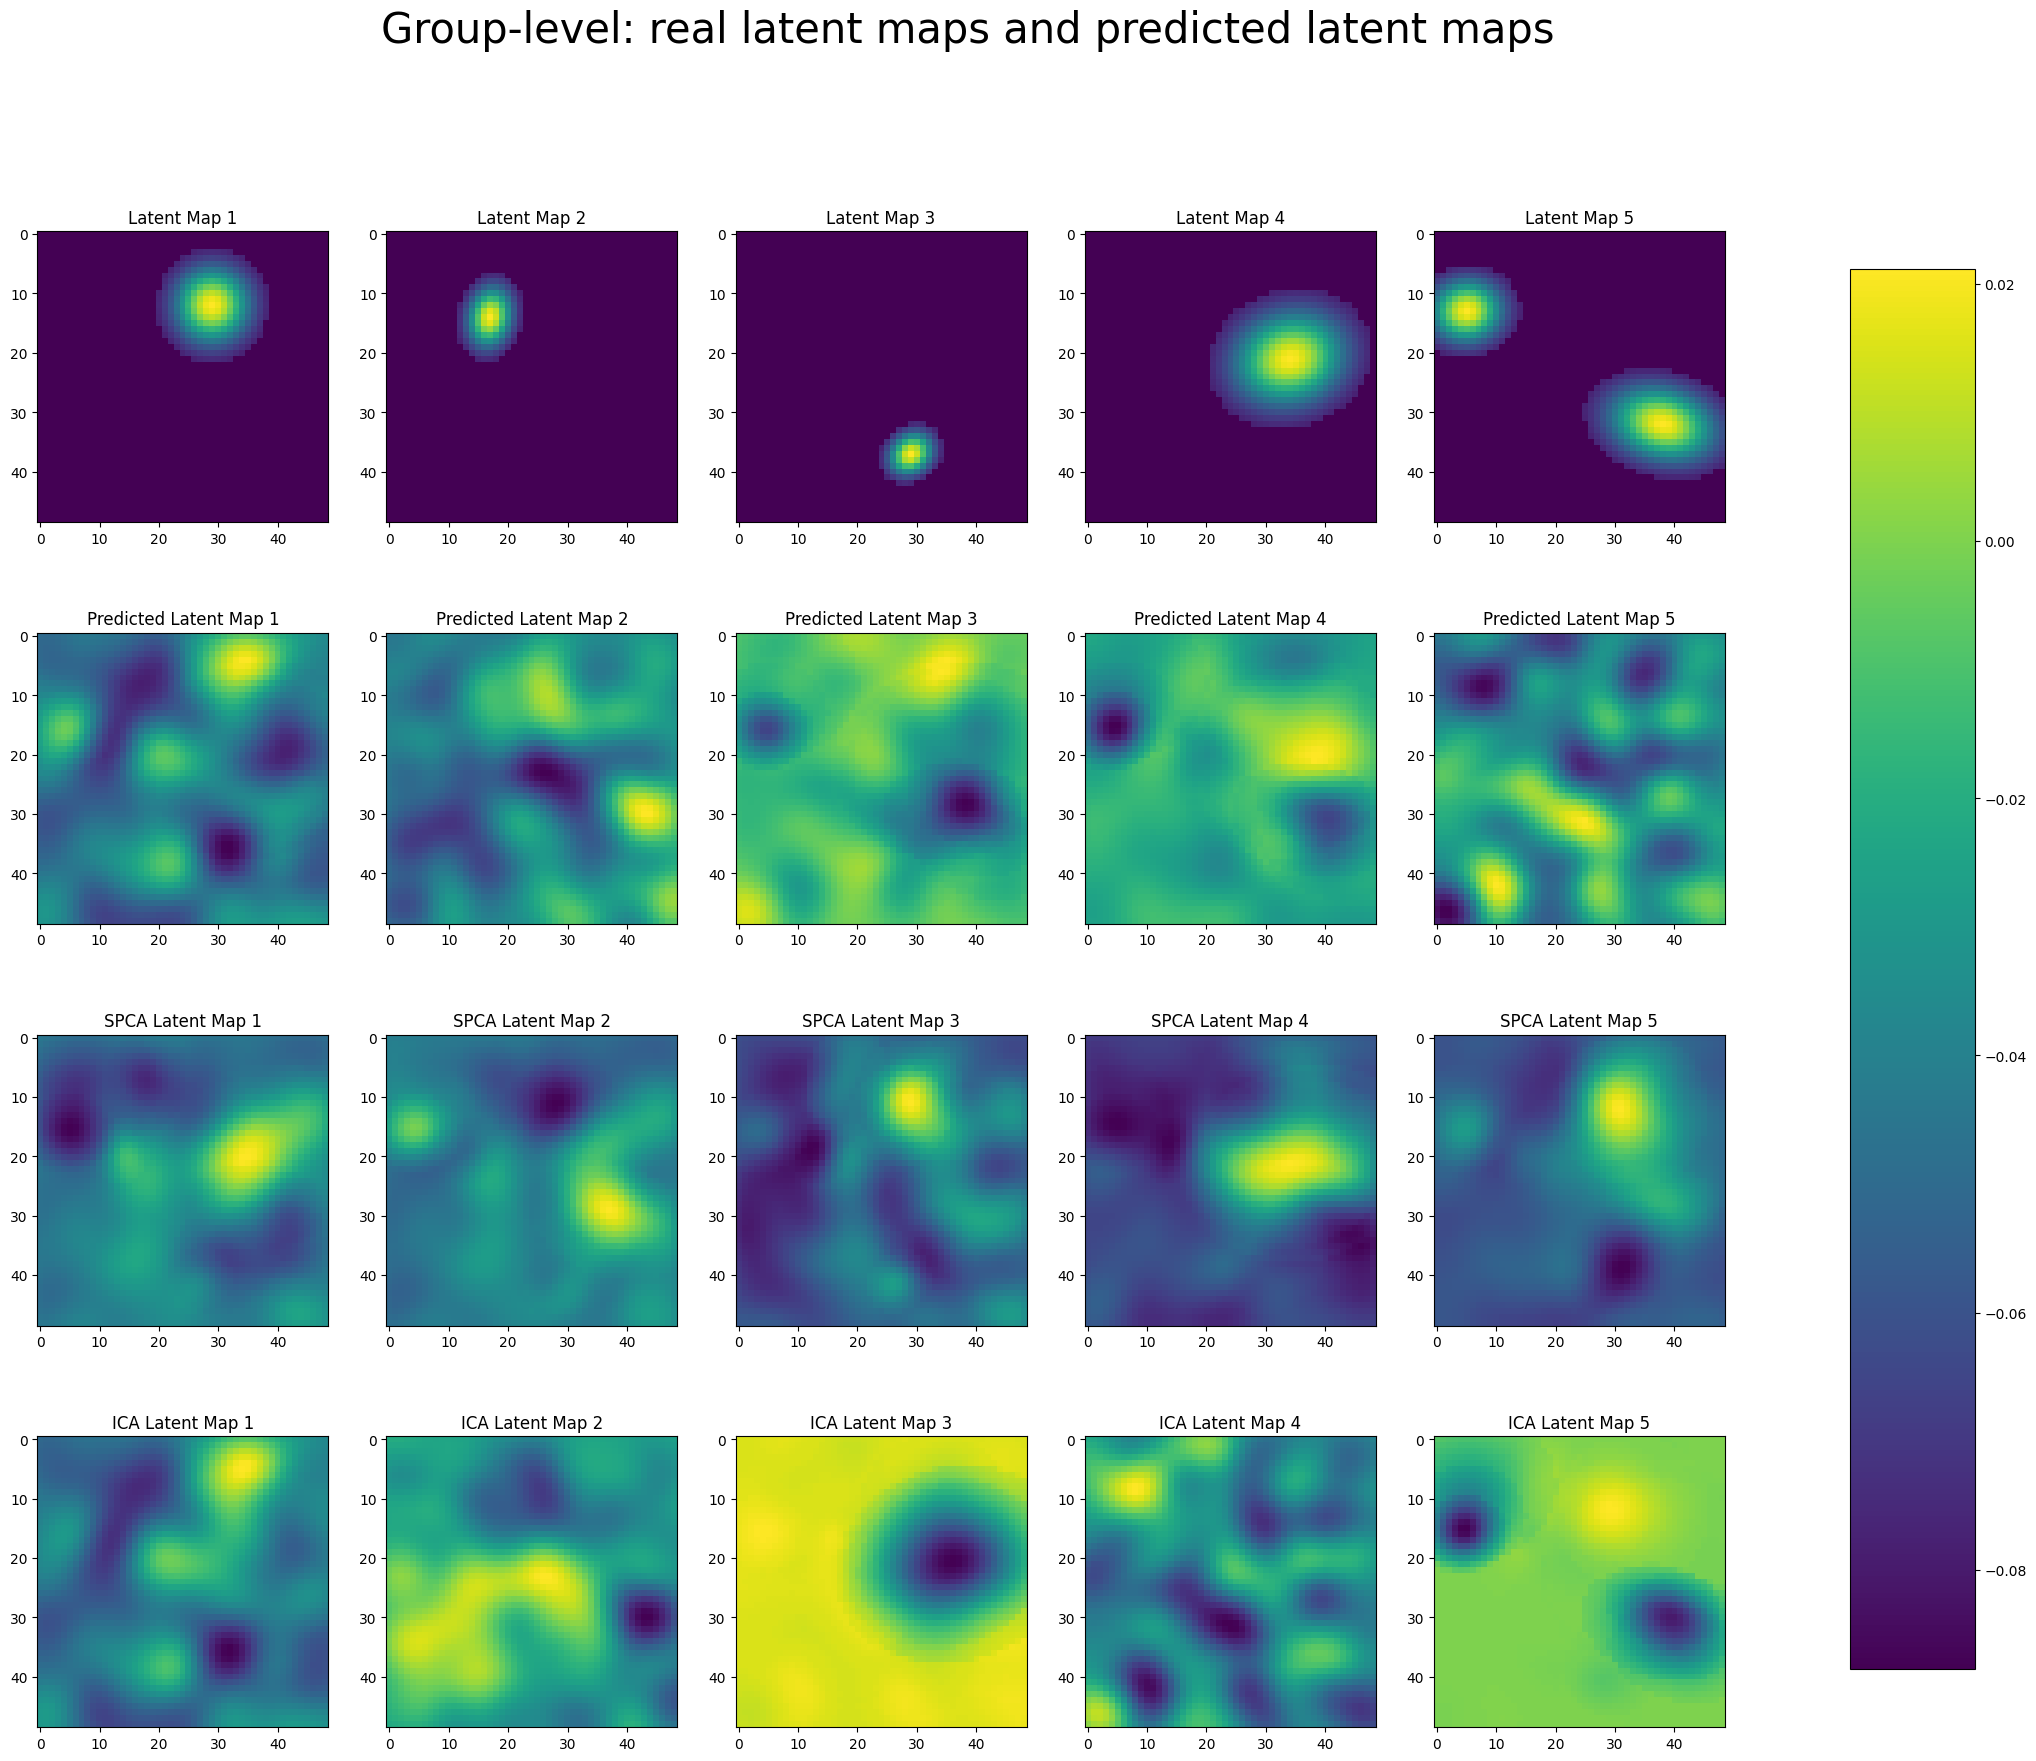

In [ ]:
fig, ax = plt.subplots(4, k, figsize=(25, 20))
fig.suptitle(f'Group-level: real latent maps and predicted latent maps ', fontsize=30)

for i in range(k):
    im = ax[0,i].imshow(latent_global_maps[i].reshape(49,49))
    im = ax[1,i].imshow(all_maps["ICA_maps"][0]["population_maps"][i].reshape(grid_length,grid_length))
    im = ax[2,i].imshow(all_maps["MSDL_maps"][0]["population_maps"][i].reshape(grid_length,grid_length))
    im = ax[3,i].imshow(all_maps["SPCA_maps"][0]["population_maps"][i].reshape(grid_length,grid_length))
    ax[0,i].set_title(f'Latent Map {i+1}')
    ax[1,i].set_title(f'Predicted Latent Map {i+1}')
    ax[2,i].set_title(f'SPCA Latent Map {i+1}')
    ax[3,i].set_title(f'ICA Latent Map {i+1}')
    
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
fig.show()


In [ ]:
# Initialize the dictionary for storing correlations
methods = ["SPCA", "ICA", "MSDL"]
modes = ["population", "subject"]
correlations = {method: {mode: {} for mode in modes} for method in methods}

# Populate the correlations dictionary with average cross-correlation values
for method in methods:
    for mode in modes:
        for l, dataset in enumerate(datasets):
            parameter = parameters[l]
            maps = all_maps[f'{method}_maps'][l]
            correlations[method][mode][parameter] = average_cross_correlation(maps, dataset, method=method, mode=mode)
            
correlations


{'SPCA': {'population': {(0, 0): 0.3828720376250481,
   (3, 0): 0.05352310024204908,
   (0, 2): 0.708400542194952,
   (3, 2): -0.0893438265316649},
  'subject': {(0, 0): -0.11962280936405137,
   (3, 0): 0.025198635630828404,
   (0, 2): -0.22580254114095005,
   (3, 2): nan}},
 'ICA': {'population': {(0, 0): 0.201390585564647,
   (3, 0): 0.39451580487473353,
   (0, 2): 0.033587441172004136,
   (3, 2): -0.1558375079648792},
  'subject': {(0, 0): 0.1268822226320838,
   (3, 0): -0.019685215229895907,
   (0, 2): -0.23480656783602144,
   (3, 2): nan}},
 'MSDL': {'population': {(0, 0): -0.06017361269235966,
   (3, 0): -0.20518829379323897,
   (0, 2): 0.33019929373410123,
   (3, 2): -0.19081308779500086},
  'subject': {(0, 0): 0.14400810968609554,
   (3, 0): 0.02204065358197872,
   (0, 2): 0.21345947349559044,
   (3, 2): nan}}}

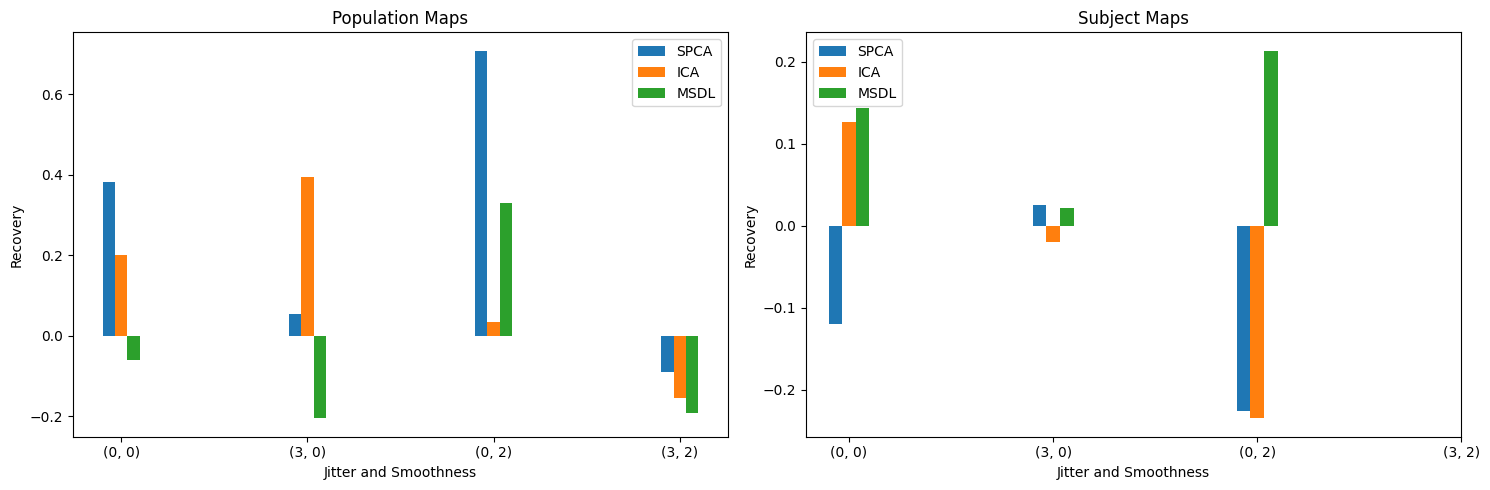

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


# Define a function to plot correlations
def plot_correlations(correlations, methods, mode, ax):
    """Plot the correlations for a given mode (population or subject) on the provided axes."""
    n_conditions = len(parameters)
    bar_width = 0.2 / len(methods)
    indices = np.arange(n_conditions)

    for i, method in enumerate(methods):
        corr_values = [correlations[method][mode][param] for param in parameters]
        ax.bar(indices + i * bar_width, corr_values, bar_width, label=method)

    ax.set_xlabel('Jitter and Smoothness')
    ax.set_ylabel('Recovery')
    ax.set_title(f'{mode.capitalize()} Maps')
    ax.set_xticks(indices + bar_width * (len(methods) - 1) / 2)
    ax.set_xticklabels(parameters)
    ax.legend()

# Create the figure and axes for the subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Plot the correlations for each mode
for ax, mode in zip(axs, modes):
    plot_correlations(correlations, methods, mode, ax)

# Display the plot with a tight layout
plt.tight_layout()
plt.show()


<center><h2><u> Second Part: Application to Brain Atlas Segmentation </u><h2><center>

<h2><u>1- Dataset </u><h2>

We fetch our data through nilearn. with a repetition time (TR) of 2 secs. The origin of the data is coming from OpenNeuro

First functional nifti image (4D) is at: /Users/emmagauillard/nilearn_data/development_fmri/development_fmri/sub-pixar123_task-pixar_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
(50, 59, 50, 168)


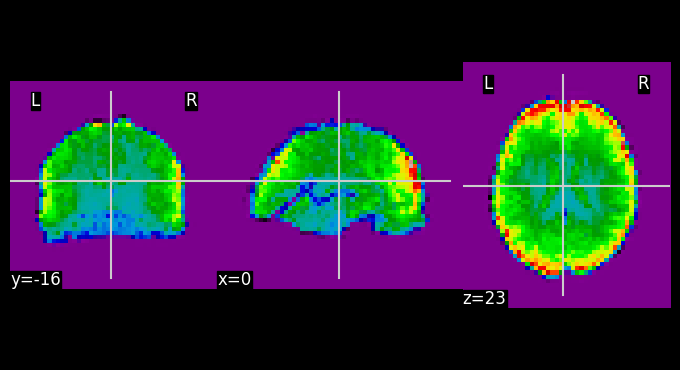

In [ ]:
from nilearn import datasets, plotting, image

rest_dataset = datasets.fetch_development_fmri(n_subjects=5)
func_filenames = rest_dataset.func  # list of 4D nifti files for each subject

# print basic information on the dataset
print(f"First functional nifti image (4D) is at: {rest_dataset.func[0]}")

func_img = image.load_img(func_filenames[0])
print(func_img.shape)
first_rsn = image.index_img(func_img, 0)


plotting.plot_epi(first_rsn)
plotting.show()